In [ ]:
# %load task2/fast_descr
import numpy as np
import cv2


class FastDescr:
    def _full_segment_test(self, candidate, pixel_surround_circle,
                           threshold, n_val, mode='d'):
        """
        Return number of elements that are darker/brighter of current element
        Returns contiguous pixels in the circle number

        https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_fast/py_fast.html
        :param candidate: 
        :param pixel_surround_circle: 
        :param threshold: 
        :param n_val: 
        :return: 
        """
        if mode == 'd':
            surround_circle_accepted_candidates = np.where(
                pixel_surround_circle < candidate + threshold)[0]
        else:
            surround_circle_accepted_candidates = np.where(
                pixel_surround_circle > candidate - threshold)[0]
        if not surround_circle_accepted_candidates.shape[0] < n_val:

            contiguous_pixels_count = 0
            p_ix = surround_circle_accepted_candidates[0]
            for ix in surround_circle_accepted_candidates:
                if p_ix + 1 == ix:
                    contiguous_pixels_count += 1
                else:
                    contiguous_pixels_count = 0
                p_ix = ix

            return contiguous_pixels_count
        else:
            return 0

    def high_speed_test(self, img, radius, threshold, n_val):
        """
        high speed test, not to consume too much time
        :param img: 
        :return: 
        """

        x_shape, y_shape = img.shape
        result_vals = np.zeros((x_shape, y_shape))
        for x_coord in range(radius, x_shape - radius):
            for y_coord in range(radius, y_shape - radius):
                candidate = img[x_coord, y_coord]
                pixel_surround_circle = [
                    img[x_coord - 1, y_coord - radius],  # 16
                    img[x_coord, y_coord - radius],  # 1
                    img[x_coord + 1, y_coord - radius],  # 2
                    img[x_coord + 2, y_coord - radius + 1],  # 3
                    img[x_coord + radius, y_coord - 1],  # 4
                    img[x_coord + radius, y_coord],  # 5
                    img[x_coord + radius, y_coord + 1],  # 6
                    img[x_coord + radius - 1, y_coord + 2],  # 7
                    img[x_coord + 1, y_coord + radius],  # 8
                    img[x_coord, y_coord + radius],  # 9
                    img[x_coord - 1, y_coord + radius],  # 10
                    img[x_coord - 2, y_coord + radius],  # 11
                    img[x_coord - radius, y_coord + 1],  # 12
                    img[x_coord - radius, y_coord],  # 13
                    img[x_coord - radius, y_coord - 1],  # 14
                    img[x_coord - radius + 1, y_coord - 2],  # 15
                ]

                pixel_check = [pixel_surround_circle[1],
                               pixel_surround_circle[9],
                               pixel_surround_circle[5],
                               pixel_surround_circle[13], ]

                pre_accept_count_brighter = np.sum([
                    int(pixel_val > candidate + threshold)  # brighter
                    for pixel_val in pixel_check
                ])

                pre_accept_count_darker = np.sum([
                    int(pixel_val < candidate - threshold)  # darker
                    for pixel_val in pixel_check
                ])
                if pre_accept_count_brighter >= 3:
                    result_vals[x_coord, y_coord] = self._full_segment_test(
                        candidate,
                        pixel_surround_circle,
                        threshold,
                        n_val,
                        mode='b')
                elif pre_accept_count_darker >= 3:
                    result_vals[x_coord, y_coord] = self._full_segment_test(
                        candidate,
                        pixel_surround_circle,
                        threshold,
                        n_val)
        return result_vals

    def detect_corners(self, img, radius=3, threshold=25, n_val=12,
                       high_speed=True):
        if not high_speed:
            raise Exception('There is not enough resources,'
                            ' use pre-check with high speed!')

        return self.high_speed_test(img, radius=radius, threshold=threshold,
                                    n_val=n_val)


def non_max_supression(img, size=5):
    x_shape, y_shape = img.shape

    res = np.zeros_like(img)
    for x in range(x_shape):
        for y in range(y_shape):
            if img[x:x + size, y:y + size].max() == img[x, y]:
                res[x, y] = img[x, y]

    return res


if __name__ == '__main__':
    img1 = cv2.imread('../images/marker_cut_rgb_42.png', cv2.IMREAD_GRAYSCALE)
    res = FastDescr().detect_corners(img1)
    non_max_supression(res)
    print(np.nonzero(res))

## Reading image and bluring it

In [186]:
from utils.gaussian_blur import gaussian_blur

In [187]:
img1 = cv2.imread('images/marker_cut_rgb_512.png', cv2.IMREAD_GRAYSCALE)

In [188]:
img1 = gaussian_blur(img1, (3, 3), 4)

In [189]:
res = FastDescr().detect_corners(img1, threshold=20)
print(np.nonzero(res)[0].shape)

res = non_max_supression(res, size=10)
print(np.nonzero(res)[0].shape)

(309,)
(276,)


In [194]:
res.shape, img1.shape

((514, 514), (514, 514))

In [192]:
from matplotlib import pyplot as plt
%matplotlib inline

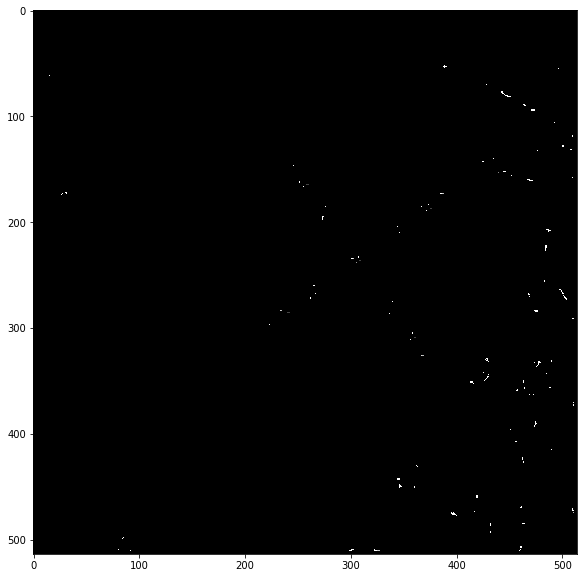

In [193]:
plt.figure(figsize=(10, 10))
plt.imshow(res, 'gray')

## display image with highlighted corners mask

In [195]:
res_display = res.copy()
res_display[res_display > 0] = 255

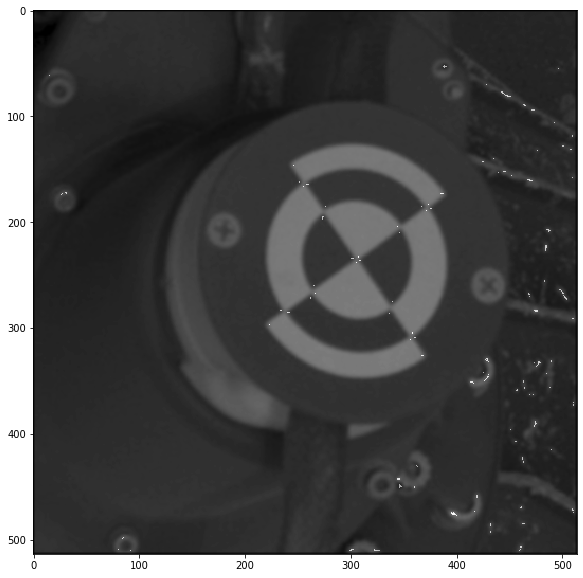

In [196]:
plt.figure(figsize=(10, 10))
plt.imshow(res_display + img1, 'gray')